# Logging simulation results

This example shows different ways to select variables for logging in a simulation, and shows how to read and write simulation results to disk.

For this example we've used [a model of the human atrial AP](https://doi.org/10.1161/CIRCRESAHA.111.253955) by Grandi et al. You can download a copy of the model here: [grandi-2011.mmt](models/grandi-2011.mmt).

## Specifying variables by name

We start by loading the [model](https://myokit.readthedocs.io/api_core/Model.html) and its associated pacing [protocol](https://myokit.readthedocs.io/api_simulations/Protocol.html) and using them to create and run a [simulation](https://myokit.readthedocs.io/api_simulations/Simulation.html):

In [2]:
import myokit

# Load a model, protocol, and script from an mmt file
model, protocol, script = myokit.load('models/grandi-2011.mmt')

# Create a simulation
sim = myokit.Simulation(model, protocol)

# Run it
log1 = sim.run(700)

Now we can take a look at the model code, and find some variables we'd like to plot, for example `membrane.V`, `ical.ICaL` and `ikur.IKur`:

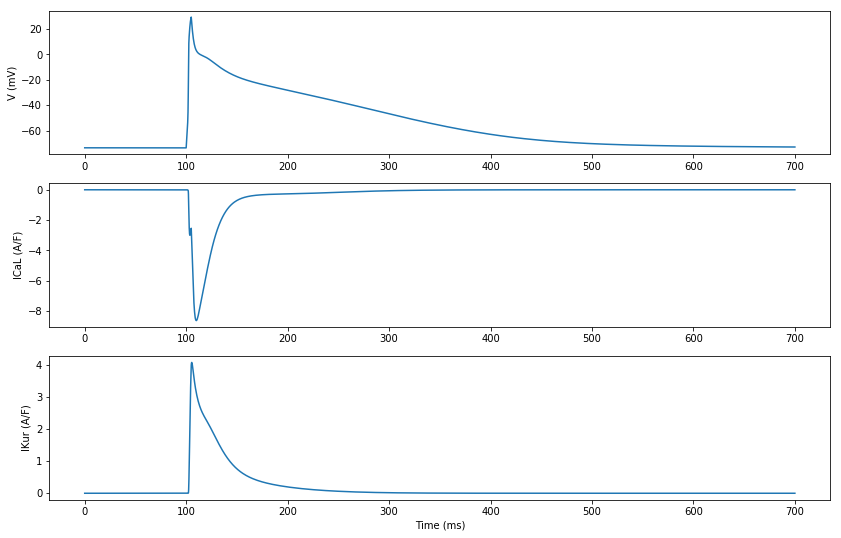

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 9))
plt.subplot(3, 1, 1)
plt.ylabel('V (mV)')
plt.plot(log1['engine.time'], log1['membrane.V'])
plt.subplot(3, 1, 2)
plt.ylabel('ICaL (A/F)')
plt.plot(log1['engine.time'], log1['ical.ICaL'])
plt.subplot(3, 1, 3)
plt.xlabel('Time (ms)')
plt.ylabel('IKur (A/F)')
plt.plot(log1['engine.time'], log1['ikur.IKur'])
plt.show()

If we know in advance that we only want to plot these variables, we can specify this before running the simulation:

In [5]:
sim.reset()
log2 = sim.run(700, log=['engine.time', 'membrane.V', 'ical.ICaL', 'ikur.IKur'])

This will make the simulation log a lot smaller:

In [6]:
print('Old log size: ' + str(len(log1)))
print('New log size: ' + str(len(log2)))

Old log size: 203
New log size: 4


This saves a bit of memory, but can also save some time:

In [7]:
b = myokit.Benchmarker()
sim.reset()
sim.run(10 * 1000)
print('With all variables: ' + str(b.time()) + ' seconds')
b.reset()
sim.reset()
sim.run(10 * 1000, log=['engine.time', 'membrane.V', 'ical.ICaL', 'ikur.IKur'])
print('With four variables: ' + str(b.time()) + ' seconds')
b.reset()
sim.reset()
sim.run(10 * 1000, log=[])
print('With zero variables: ' + str(b.time()) + ' seconds')

With all variables: 0.21605555300016022 seconds
With four variables: 0.08856553000009626 seconds
With zero variables: 0.07790796199992656 seconds


## Logging derivatives

Derivatives of state variables can also be logged.
These are specified using the syntax `dot(x)`, where `x` is the name of the state variable:

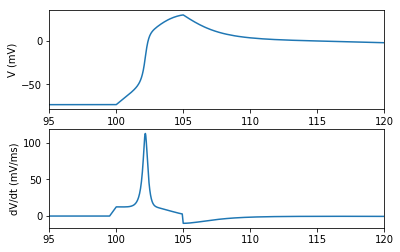

In [8]:
sim.reset()
log = sim.run(200, log=['engine.time', 'membrane.V', 'dot(membrane.V)'])

plt.figure()
plt.subplot(2, 1, 1)
plt.xlim(95, 120)
plt.ylabel('V (mV)')
plt.plot(log['engine.time'], log['membrane.V'])
plt.subplot(2, 1, 2)
plt.xlim(95, 120)
plt.ylabel('dV/dt (mV/ms)')
plt.plot(log['engine.time'], log['dot(membrane.V)'])
plt.show()

## Using logging flags

In addition to specifying variables by name, we can use integer 'flags' to specify groups of variables.
For example, to log only state variables, use the `LOG_STATE` flag:

In [9]:
sim.reset()
log = sim.run(1000, log=myokit.LOG_STATE)

print(model.count_states())
print(len(log))

41
41


Typically, we'll also want to log time though, which we can achieve with:

In [10]:
sim.reset()
log = sim.run(600, log=myokit.LOG_STATE + myokit.LOG_BOUND)

print(model.count_states())
print(len(log))

41
43


The `LOG_BOUND` flag tells the simulator to log any variable "bound" to external inputs: in this case the time variable and the variable that's used to create a pacing signal. These variables are called "bound variables in Myokit (see [here](https://myokit.readthedocs.io/syntax/model.html#interfacing-with-the-outside-world)).

What about currents?
These are not state variables or bound variables.
From a mathematical point of view, they are simply part of the equations to calculate the state variable derivatives.
In Myokit we call any such variable an "intermediate variable", and we can log all intermediate variables using `LOG_INTER`:

In [11]:
sim.reset()
log = sim.run(600, log=myokit.LOG_INTER + myokit.LOG_BOUND)

print(len(log))

121


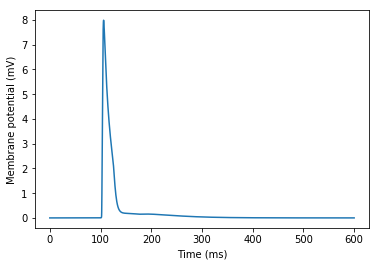

In [29]:
plt.figure()
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.plot(log['engine.time'], log['ito.Ito'])
plt.show()

The full list of flags is given [here](https://myokit.readthedocs.io/api_simulations/DataLog.html#myokit.prepare_log).

## Continuing a previous simulation

A final option for the `log` argument is to pass in an existing simulation log. In this case, the newly logged entries will be appended to the ones already in the log.

Let's run the first 150ms of a simulation:

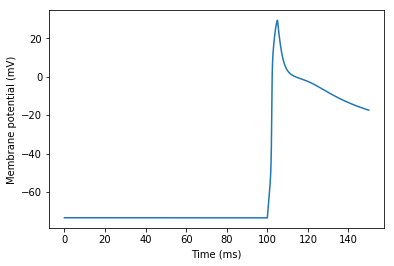

In [30]:
sim.reset()

log1 = sim.run(150)

plt.figure()
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.plot(log1['engine.time'], log1['membrane.V'])
plt.show()

We can run again, to create a second log, and plot both:

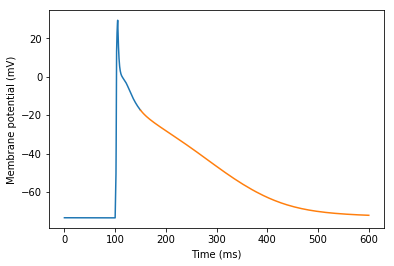

In [31]:
log2 = sim.run(450)

plt.figure()
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.plot(log1['engine.time'], log1['membrane.V'], label='First simulation')
plt.plot(log2['engine.time'], log2['membrane.V'], label='Second simulation')
plt.show()

But we can also _pass in the original log_, and then the new results will be appended to the old one:

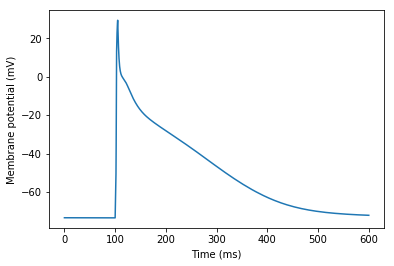

In [32]:
sim.reset()

log = sim.run(150)
log = sim.run(450, log=log)

plt.figure()
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.plot(log['engine.time'], log['membrane.V'])
plt.show()

This can be useful if we want to make changes during a simulation:

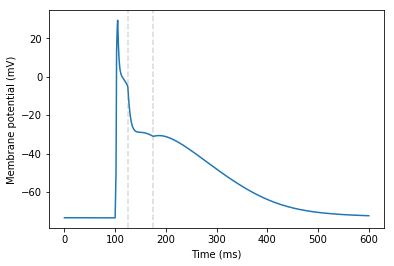

In [34]:
sim.reset()

sim.set_constant('ical.block', 0)
log = sim.run(125)
sim.set_constant('ical.block', 1)
log = sim.run(50, log=log)
sim.set_constant('ical.block', 0)
log = sim.run(425, log=log)

plt.figure()
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.plot(log['engine.time'], log['membrane.V'])
plt.axvline(125, linestyle='--', color='gray', alpha=0.3)
plt.axvline(175, linestyle='--', color='gray', alpha=0.3)
plt.show()

_(In this example, the model we used has a variable "ical.block" that lets us block the L-type calcium current. We can use the_ [set_constant()](https://myokit.readthedocs.io/api_simulations/Simulation.html#myokit.Simulation.set_constant) _method to change any model constants/parameters in a simulation.)_

## Storing results to disk

Instead of plotting or analysing results directly, [DataLog](https://myokit.readthedocs.io/api_simulations/DataLog.html) objects returned by simulations can be written to the filesystem.

The _fastest_ way to do this is to use the DataLog's `save` and `load` methods:

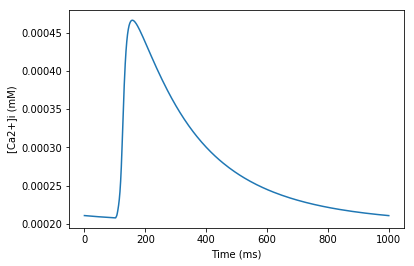

In [46]:
# Run a simulation and store the results
sim.reset()
log = sim.run(1000, log=['engine.time', 'calcium.Ca_i'])
log.save('my_simulation.zip')

# Load and plot the results
log = myokit.DataLog.load('my_simulation.zip')

plt.figure()
plt.xlabel('Time (ms)')
plt.ylabel('[Ca2+]i (mM)')
plt.plot(log['engine.time'], log['calcium.Ca_i'])
plt.show()

The file format used by `save` and `load` is a compressed binary file, which is a very efficient way to store the data, but not a very _interoperable_ one.

An alternative is to use [CSV files](https://en.wikipedia.org/wiki/Comma-separated_values), which can be written and read by a huge number of other tools:

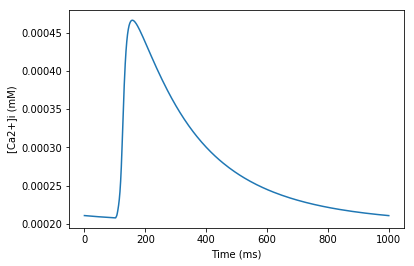

In [47]:
# Save to disk
log.save_csv('my_simulation.csv')

# Load from disk and plot
log = myokit.DataLog.load_csv('my_simulation.csv')
plt.figure()
plt.xlabel('Time (ms)')
plt.ylabel('[Ca2+]i (mM)')
plt.plot(log['engine.time'], log['calcium.Ca_i'])
plt.show()

Because of this compatibility with other tools, storing to CSV is the most common way to save and load Myokit data. However, in situations where speed or disk space is important (for example when writing very large simulation logs to disk, or when saving and loading repeatedly), using the binary format can be a more efficient choice.